In [1]:
import pandas as pd
import numpy as np
np.random.seed(77)
import seaborn as sns
import more_itertools
import os
import io
import re
import requests
import PIL
import itertools
import random
import h5py
import gzip
import pickle

import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

from collections import Counter
from sklearn.metrics import silhouette_score, pairwise_distances, silhouette_samples
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import cdist
from scipy.stats import hypergeom, pearsonr, mannwhitneyu
from statsmodels.stats.multitest import multipletests

from joblib import Parallel, delayed
import multiprocessing

from tqdm import tqdm

#Functions

In [2]:
def cosine_similarity(df, cluster_col):
    labels = df[cluster_col].unique()
    cos_df = pd.DataFrame(labels, columns=[cluster_col])
    cos_df['Average Cosine Similarity'] = np.nan

    grouped_clusters = df.groupby(cluster_col)

    for cluster, group in tqdm(grouped_clusters):
        embeddings = np.vstack(group['Embeddings'].values)

        if embeddings.size == 0 or len(embeddings) < 2:
            cos_df.loc[cos_df[cluster_col] == cluster, 'Average Cosine Similarity'] = 1.0
            continue

        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        dot_products = np.dot(embeddings, embeddings.T)
        cosine_sim_matrix = dot_products / (norms @ norms.T)

        triu_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
        cosine_sim_values = cosine_sim_matrix[triu_indices]

        avg_similarity = np.mean(cosine_sim_values)
        cos_df.loc[cos_df[cluster_col] == cluster, 'Average Cosine Similarity'] = avg_similarity

    return cos_df

def jaccard_distance(list1, list2):
    set1, set2 = set(list1), set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_dist = 1 - intersection / union

    return jaccard_dist

def precompute_neighbors(df, cluster_col, max_neighbors=30):
    umap_neighbors = {}
    embedding_neighbors = {}

    for index, row in tqdm(df.iterrows(), total=len(df)):
        protein = row['Entry']
        cluster_label = row[cluster_col]
        same_cluster_df = df[df[cluster_col] == cluster_label]
        num_proteins_in_cluster = len(same_cluster_df)
        neighbors = min(max_neighbors, num_proteins_in_cluster)
        # Find closest neighbors in 2D space
        target_umap_point = row[['UMAP 1', 'UMAP 2']].values.astype(np.float64)
        other_umap_points = df[df['Entry'] != protein][['UMAP 1', 'UMAP 2']].values.astype(np.float64)
        umap_distances = cdist(target_umap_point.reshape(1, -1), other_umap_points, metric='euclidean').flatten()
        umap_closest_indices = np.argsort(umap_distances)[:neighbors]
        umap_neighbors[protein] = df.iloc[umap_closest_indices]['Entry'].tolist()

        # Find closest neighbors in ambient space
        target_embedding_point = row['Embeddings']
        other_embedding_points = np.vstack(df[df['Entry'] != protein]['Embeddings'].values)
        embedding_distances = cdist(target_embedding_point.reshape(1, -1), other_embedding_points, metric='euclidean').flatten()
        embedding_closest_indices = np.argsort(embedding_distances)[:neighbors]
        embedding_neighbors[protein] = df.iloc[embedding_closest_indices]['Entry'].tolist()

    return umap_neighbors, embedding_neighbors

def avg_jaccard_dist(df, cluster_col):
    labels = df[cluster_col].unique()
    jac_df = pd.DataFrame(labels, columns=[cluster_col])
    jac_df['Average Jaccard Distance'] = np.nan

    umap_neighbors, embedding_neighbors = precompute_neighbors(df, cluster_col)

    for cluster in tqdm(labels):
        current_df = df[df[cluster_col] == cluster]
        jdist_list = []

        for index, row in current_df.iterrows():
            protein = row['Entry']
            neighbors_umap = umap_neighbors[protein]
            neighbors_embeddings = embedding_neighbors[protein]

            jdist = jaccard_distance(neighbors_umap, neighbors_embeddings)
            jdist_list.append(jdist)

        avg_jacdist = np.mean(jdist_list)
        jac_df.loc[jac_df[cluster_col] == cluster, 'Average Jaccard Distance'] = avg_jacdist

    return jac_df

In [3]:
def threshold_analysis(df, cos_df, jac_df, cluster_col):
    sil_vals = silhouette_samples(df[['UMAP 1', 'UMAP 2']], df[cluster_col])
    df['silhouette_score'] = sil_vals

    avg_sil_per_clus = df.groupby(cluster_col)['silhouette_score'].mean()

    thresholds = np.arange(0, 1, 0.05)
    cos_means = []
    jac_means = []
    cos_std = []
    jac_std = []

    for threshold in thresholds:
        clusters_above = avg_sil_per_clus[avg_sil_per_clus > threshold].index
        cos_values = cos_df[cos_df[cluster_col].isin(clusters_above)]['Average Cosine Similarity']
        jac_values = jac_df[jac_df[cluster_col].isin(clusters_above)]['Average Jaccard Distance']
        cos_means.append(cos_values.mean())
        jac_means.append(jac_values.mean())
        cos_std.append(cos_values.std()/ np.sqrt(len(cos_values)))
        jac_std.append(jac_values.std()/ np.sqrt(len(jac_values)))

    plt.figure(figsize=(10, 6))

    plt.errorbar(thresholds, cos_means, yerr=cos_std, label='Average Cosine Similarity', marker='o', capsize=5)
    plt.errorbar(thresholds, jac_means, yerr=jac_std, label='Average Jaccard Distance', marker='o', capsize=5)

    plt.xlabel('Silhouette Score Threshold')
    plt.ylabel('Mean Score')
    plt.legend()
    plt.show()

In [4]:
def plot_comparison(df, cluster_col, cluster_list, separation):
    def categorize_cluster(label):
        if label in cluster_list:
            return separation
        else:
            return 'Other'

    plot_df = df.copy()
    plot_df[cluster_col] = plot_df[cluster_col].apply(categorize_cluster)

    palette = sns.color_palette("deep", 10)
    colors = {separation: palette[0], 'Other': palette[1]}
    plot_df['Color'] = plot_df[cluster_col].map(colors)

    plt.figure(figsize=(10, 6))

    subset_other = plot_df[plot_df[cluster_col] == 'Other']
    plt.scatter(subset_other['UMAP 1'], subset_other['UMAP 2'], label='Other', color=colors['Other'])

    subset_sep = plot_df[plot_df[cluster_col] == separation]
    plt.scatter(subset_sep['UMAP 1'], subset_sep['UMAP 2'], label=separation, color=colors[separation])

    plt.xlabel('UMAP 1', fontsize=18, fontweight='bold')
    plt.ylabel('UMAP 2', fontsize=18, fontweight='bold')

    plt.xticks([])
    plt.yticks([])

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    handles, labels = ax.get_legend_handles_labels()
    order = [1, 0]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=14, loc='upper right')

    plt.show()

    return cluster_list

In [5]:
def cosine_jaccard_violin_plot(jac_df, cos_df, sep_clus, cluster_col):
    merged_df = jac_df.merge(cos_df[[cluster_col, 'Average Cosine Similarity']], on=cluster_col, how='left')
    merged_df['Category'] = merged_df[cluster_col].apply(lambda x: 'Well-separated' if x in sep_clus else 'Other')

    separated_data = merged_df[merged_df['Category'] == 'Well-separated']
    other_data = merged_df[merged_df['Category'] == 'Other']
    cos_stat, cos_p_value = mannwhitneyu(separated_data['Average Cosine Similarity'], other_data['Average Cosine Similarity'])
    jac_stat, jac_p_value = mannwhitneyu(separated_data['Average Jaccard Distance'], other_data['Average Jaccard Distance'])

    data = []
    categories = []
    types = []

    #Collect the data for each similarity type and category
    for sim_type, sim_name in zip(['Average Jaccard Distance', 'Average Cosine Similarity'],
                                  ['Jaccard Distance', 'Cosine Similarity']):
        for index, row in merged_df.iterrows():
            data.append(row[sim_type])  # Extend the data with the similarity values (lists)
            categories.append(row['Category'])  # Add the Category label for each value
            types.append(sim_name)  # Add the similarity type name for each value

    plt.figure(figsize=(12, 6))
    sns.violinplot(x=types, y=data, hue=categories, hue_order=['Well-separated', 'Other'],
                   split=True, inner="quart", palette=sns.color_palette("deep")[:2])

    plt.ylabel('Mean Similarity Score', fontsize=18, fontweight='bold')
    plt.legend(fontsize=14, loc='lower right')
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=14)

    def add_significance_bar(ax, x1, x2, y, p_val, height=0.02, fontsize=14):
        bar_color = 'black'
        ax.plot([x1, x1, x2, x2], [y, y+height, y+height, y], lw=1.5, c=bar_color)
        if p_val < 0.001:
            text = '***'
        elif p_val < 0.01:
            text = '**'
        elif p_val < 0.05:
            text = '*'
        else:
            text = 'ns'
        ax.text((x1 + x2) * 0.5, y + height, text, ha='center', va='bottom', color=bar_color, fontsize=fontsize, fontweight='bold')

    add_significance_bar(plt.gca(), -0.25, 0.25, 1.1, jac_p_value)
    add_significance_bar(plt.gca(), 0.75, 1.25, 1.1, cos_p_value)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

In [6]:
def find_closest_clusters(centroids):
    # Calculate pairwise distances between all centroids
    distances = np.linalg.norm(centroids.values[:, None] - centroids.values, axis=2)
    closest_clusters = {}

    # For each cluster, find the closest one (excluding itself)
    for i, cluster_label in enumerate(centroids.index):
        closest_idx = np.argsort(distances[i])[1]  # [1] skips the zero distance to itself
        closest_clusters[cluster_label] = centroids.index[closest_idx]

    return closest_clusters

def create_cluster_dictionary(df, clus_col):
    # Calculate centroids
    centroids = df.groupby(clus_col)[['UMAP 1', 'UMAP 2']].mean()

    # Find the closest clusters
    closest_clusters = find_closest_clusters(centroids)

    # Create the dictionary with closest and random cluster labels
    cluster_dict = {}
    cluster_labels = centroids.index.tolist()

    for label in cluster_labels:
        # Find the closest cluster
        closest = closest_clusters[label]

        # Choose a random cluster different from the current one
        random_cluster = random.choice([l for l in cluster_labels if l != label & l != closest])

        # Add to dictionary
        cluster_dict[label] = {'closest': closest, 'random': random_cluster}

    return cluster_dict

In [7]:
def get_distsim(current_cluster, other_cluster=None, centroid_dist=0):
    similarities = []
    distances = []

    if other_cluster is None:
        embeddings = np.vstack(current_cluster['Embeddings'].values)
        if embeddings.size == 0 or len(embeddings) < 2:
            similarities = [1]

        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        dot_products = np.dot(embeddings, embeddings.T)
        cosine_sim_matrix = dot_products / (norms @ norms.T)

        triu_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
        cosine_sim_values = cosine_sim_matrix[triu_indices]

        similarities.extend(cosine_sim_values)
    else:
        current_embeddings = np.vstack(current_cluster['Embeddings'].values)
        other_embeddings = np.vstack(other_cluster['Embeddings'].values)
        current_norms = np.linalg.norm(current_embeddings, axis=1, keepdims=True)
        other_norms = np.linalg.norm(other_embeddings, axis=1, keepdims=True)

        # Compute cosine similarities between each pair from current_cluster and other_cluster
        for idx, seq in enumerate(current_cluster['Sequence']):
            # Calculate cosine similarities for this protein (seq) with all proteins in other_cluster
            current_embedding = current_embeddings[idx].reshape(1, -1)  # Reshape for matrix multiplication
            dot_products = np.dot(current_embedding, other_embeddings.T)
            # Normalize dot products to get cosine similarities
            cosine_sim_values = dot_products / (current_norms[idx] * other_norms.T)
            # Flatten and append the cosine similarities
            similarities.extend(cosine_sim_values.flatten())

    distances = [centroid_dist] * len(similarities)

    return distances, similarities


def pairwise_correlations(df, col_name, neighbors, cluster_list):
    cluster_df = pd.DataFrame({col_name: sorted(df[col_name].unique())})
    cluster_df = cluster_df[cluster_df[col_name].isin(cluster_list)]

    for col in ['Distances CS', 'Similarities CS', 'Neighbor', 'Distances NNS', 'Similarities NNS',
                'Random', 'Distances RNS', 'Similarities RNS', 'Correlations', 'Total Correlation']:
        if col not in cluster_df.columns:
            cluster_df[col] = np.nan
        cluster_df[col] = cluster_df[col].astype(object)

    for index, row in tqdm(cluster_df.iterrows(), total=cluster_df.shape[0]):
        label = row[col_name]
        current_cluster = df[df[col_name] == label]
        current_centroid = np.mean(current_cluster[['UMAP 1', 'UMAP 2']], axis=0)

        neighbor_label = neighbors[label]['closest']
        nearest_cluster = df[df[col_name] == neighbor_label]
        nearest_centroid = np.mean(nearest_cluster[['UMAP 1', 'UMAP 2']], axis=0)
        nearest_dist = np.linalg.norm(current_centroid - nearest_centroid)

        random_label = neighbors[label]['random']
        random_cluster = df[df[col_name] == random_label]
        random_centroid = np.mean(random_cluster[['UMAP 1', 'UMAP 2']], axis=0)
        random_dist = np.linalg.norm(current_centroid - random_centroid)

        all_distances_cs = []
        all_similarities_cs = []
        all_distances_nns = []
        all_similarities_nns = []
        all_distances_rns = []
        all_similarities_rns = []
        correlations = []

        distances_cs, similarities_cs = get_distsim(current_cluster)
        distances_nns, similarities_nns = get_distsim(current_cluster, nearest_cluster, nearest_dist)
        distances_rns, similarities_rns = get_distsim(current_cluster, random_cluster, random_dist)

        all_distances_cs.extend(distances_cs)
        all_similarities_cs.extend(similarities_cs)
        all_distances_nns.extend(distances_nns)
        all_similarities_nns.extend(similarities_nns)
        all_distances_rns.extend(distances_rns)
        all_similarities_rns.extend(similarities_rns)

        seq_distances = np.hstack([distances_cs, distances_nns, distances_rns])
        seq_similarities = np.hstack([similarities_cs, similarities_nns, similarities_rns])

        correlation, _ = pearsonr(seq_distances, seq_similarities)
        correlations.append(correlation)

        cluster_df.at[index, 'Distances CS'] = distances_cs
        cluster_df.at[index, 'Similarities CS'] = similarities_cs
        cluster_df.at[index, 'Distances NNS'] = distances_nns
        cluster_df.at[index, 'Similarities NNS'] = similarities_nns
        cluster_df.at[index, 'Distances RNS'] = distances_rns
        cluster_df.at[index, 'Similarities RNS'] = similarities_rns
        cluster_df.at[index, 'Correlations'] = correlations
        cluster_df.at[index, 'Neighbor'] = neighbor_label
        cluster_df.at[index, 'Random'] = random_label

        total_distances = all_distances_cs + all_distances_nns + all_distances_rns
        total_similarities = all_similarities_cs + all_similarities_nns + all_similarities_rns
        total_correlation, _ = pearsonr(total_distances, total_similarities)
        cluster_df.at[index, 'Total Correlation'] = total_correlation

    return cluster_df

In [8]:
def similarity_violin_plot(df, sep_clus, bad_clus, cluster_col):
    palette = sns.color_palette("deep")[:2]
    filtered_df = df[df[cluster_col].isin(sep_clus + bad_clus)].copy()
    filtered_df['Category'] = filtered_df[cluster_col].apply(lambda x: 'Well-separated' if x in sep_clus else 'Poorly-separated')

    data = []
    categories = []
    types = []

    # Collect the data for each similarity type and category
    for sim_type, sim_name in zip(['Similarities CS', 'Similarities NNS', 'Similarities RNS'],
                                  ['Same Cluster', 'Nearest Neighbor', 'Random Neighbor']):
        for index, row in filtered_df.iterrows():
            data.extend(row[sim_type])  # Extend the data with the similarity values (lists)
            categories.extend([row['Category']] * len(row[sim_type]))  # Add the Category label for each value
            types.extend([sim_name] * len(row[sim_type]))  # Add the similarity type name for each value

    plt.figure(figsize=(12, 6))
    sns.violinplot(x=types, y=data, hue=categories, hue_order=['Well-separated', 'Poorly-separated'],
                   split=True, inner="quart", palette=palette)

    plt.ylabel('Mean Cosine Similarity', fontsize=12, fontweight='bold')
    plt.legend(fontsize=12, loc='lower left')
    plt.xticks(fontsize=12, fontweight='bold')

    def add_significance_bar(ax, x1, x2, y, cohensd, bar_color, height=0.02, fontsize=12):
        ax.plot([x1, x1, x2, x2], [y, y+height, y+height, y], lw=1.5, c=bar_color)
        ax.text((x1 + x2) * 0.5, y + height, f'd={round(cohensd, 2)}', ha='center', va='bottom', color='black', fontsize=fontsize, fontweight='bold')

    poor_correlations = df[df[cluster_col].isin(bad_clus)]
    poor_CS = poor_correlations['Similarities CS'].sum()
    poor_NNS = poor_correlations['Similarities NNS'].sum()
    poor_RNS = poor_correlations['Similarities RNS'].sum()
    well_correlations = df[df[cluster_col].isin(sep_clus)]
    well_CS = well_correlations['Similarities CS'].sum()
    well_NNS = well_correlations['Similarities NNS'].sum()
    well_RNS = well_correlations['Similarities RNS'].sum()
    well_CS = np.array(well_CS, dtype=np.float64)
    well_NNS = np.array(well_NNS, dtype=np.float64)
    well_RNS = np.array(well_RNS, dtype=np.float64)
    poor_CS = np.array(poor_CS, dtype=np.float64)
    poor_NNS = np.array(poor_NNS, dtype=np.float64)
    poor_RNS = np.array(poor_RNS, dtype=np.float64)

    # For well-separated clusters
    well_cohens_d1 = (well_CS.mean() - well_NNS.mean()) / np.sqrt((well_CS.var(ddof=1) + well_NNS.var(ddof=1)) / 2)
    well_cohens_d2 = (well_NNS.mean() - well_RNS.mean()) / np.sqrt((well_NNS.var(ddof=1) + well_RNS.var(ddof=1)) / 2)

    # For poorly-separated clusters
    poor_cohens_d1 = (poor_CS.mean() - poor_NNS.mean()) / np.sqrt((poor_CS.var(ddof=1) + poor_NNS.var(ddof=1)) / 2)
    poor_cohens_d2 = (poor_NNS.mean() - poor_RNS.mean()) / np.sqrt((poor_NNS.var(ddof=1) + poor_RNS.var(ddof=1)) / 2)
    add_significance_bar(plt.gca(), -0.24, 0.74, 1.2, well_cohens_d1, palette[0])
    add_significance_bar(plt.gca(), 0.24, 1.24, 1.1, poor_cohens_d1, palette[1])
    add_significance_bar(plt.gca(), 0.76, 1.76, 1.2, well_cohens_d2, palette[0])
    add_significance_bar(plt.gca(), 1.26, 2.26, 1.1, poor_cohens_d2, palette[1])

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

#Results Pipeline

In [9]:
file_path = 'mtuberculosis_proteome_df.csv'
#'rSAM_proteome_df.csv'
#'mycobacterium_proteome_df.csv'
#'plasmodium_proteome_df.csv'
#'host_pathogen_proteome_df.csv'
#'azoreductase_proteome_df.csv'
#'sterol_proteins_proteome_df.csv'

df = pd.read_csv(file_path)
df['Embeddings'] = df['Embeddings'].apply(lambda x: np.fromstring(x.strip('[]'), sep=','))

In [10]:
cosine_similarity_df = cosine_similarity(df, 'Cluster Label')
jaccard_distance_df = avg_jaccard_dist(df, 'Cluster Label')

100%|██████████| 96/96 [00:00<00:00, 289.45it/s]


Mean score for both cosine similarity and Jaccard distance improves as we increase the silhouette score threshold.  

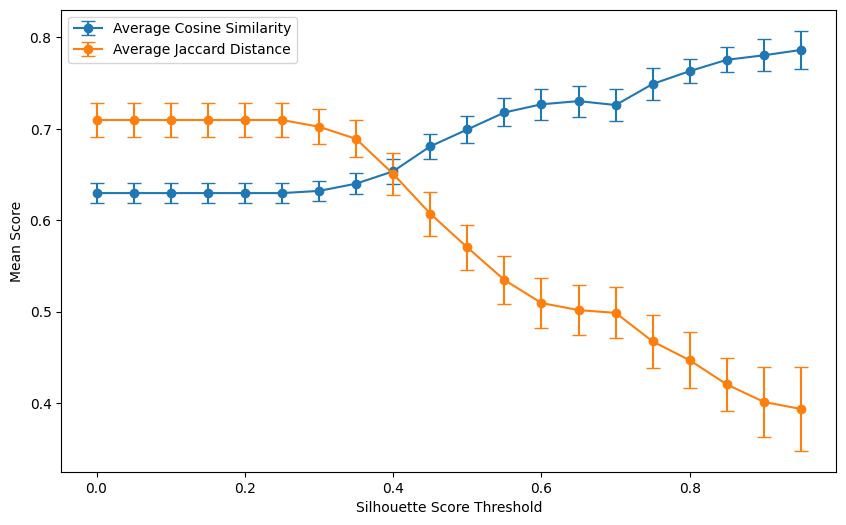

In [11]:
threshold_analysis(df, cosine_similarity_df, jaccard_distance_df, 'Cluster Label')

Well-separated clusters tend to be farther away from the large concentration of points in the center of the plots.

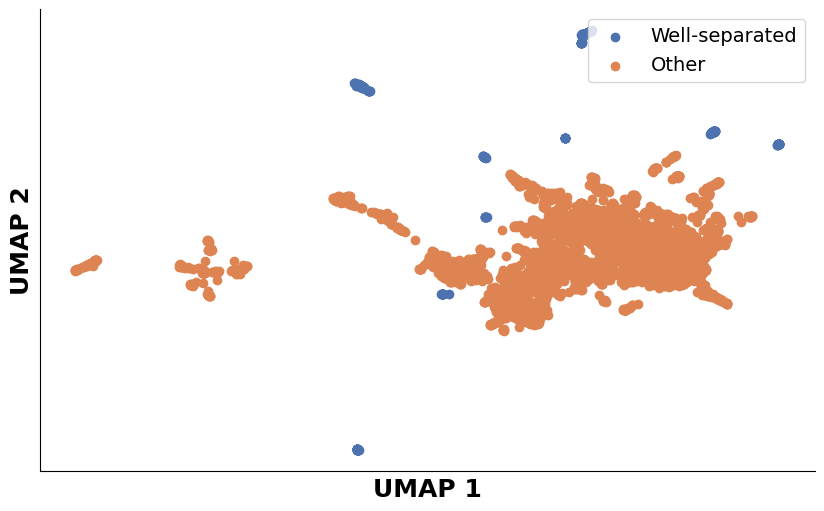

Index([4, 7, 11, 14, 24, 38, 40, 54, 90], dtype='int64', name='Cluster Label')


In [14]:
avg_silhouette_score_per_cluster = df.groupby('Cluster Label')['silhouette_score'].mean()
well_clusters = avg_silhouette_score_per_cluster[avg_silhouette_score_per_cluster > 0.95].index
plot_comparison(df, 'Cluster Label', well_clusters, 'Well-separated')
print(well_clusters)

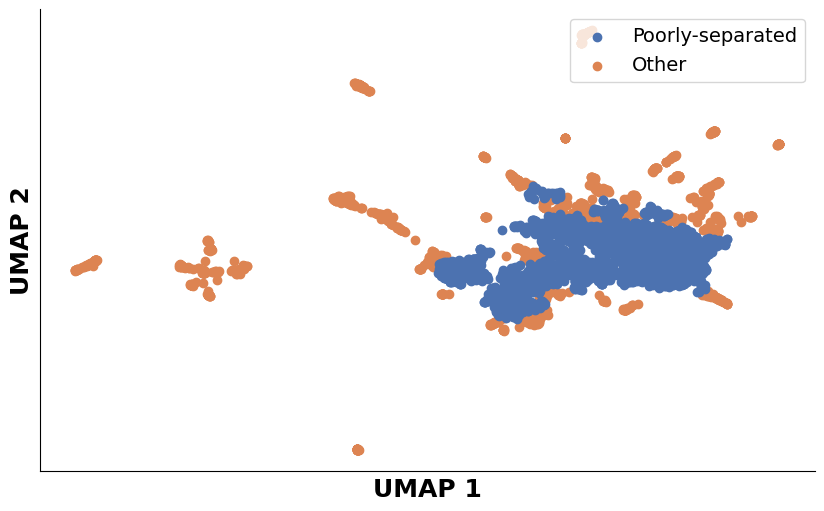

Index([ 1,  3,  6,  9, 12, 13, 15, 17, 21, 25, 26, 27, 28, 29, 32, 34, 36, 37,
       39, 45, 46, 47, 48, 51, 53, 55, 56, 58, 59, 62, 63, 64, 66, 69, 70, 73,
       74, 75, 76, 77, 79, 83, 85, 86, 88, 89, 93, 94, 95],
      dtype='int64', name='Cluster Label')


In [15]:
fuzzy_clusters = avg_silhouette_score_per_cluster[avg_silhouette_score_per_cluster < 0.5].index
plot_comparison(df, 'Cluster Label', fuzzy_clusters, 'Poorly-separated')
print(fuzzy_clusters)

Well-separated clusters show better cosine similairty and Jaccard distance scores. We thus propose that they preserve ambient space information better than other regions in the projection.

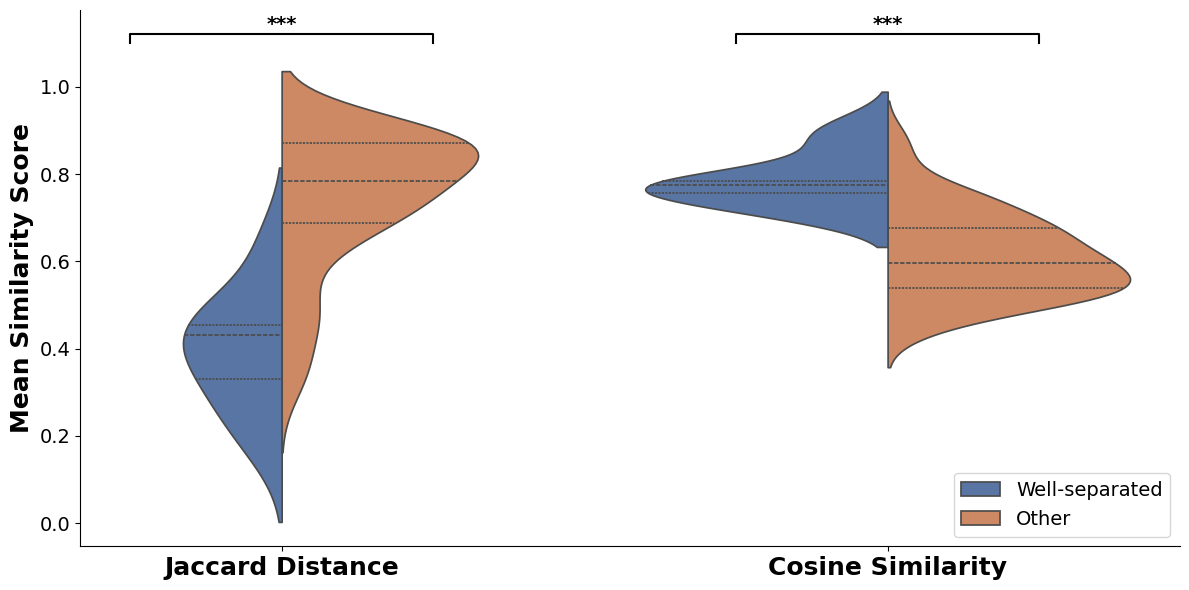

In [16]:
cosine_jaccard_violin_plot(jaccard_distance_df, cosine_similarity_df, well_clusters, 'Cluster Label')

In [17]:
cluster_dict = create_cluster_dictionary(df, 'Cluster Label')
print(cluster_dict)
cluster_list = df['Cluster Label'].unique()
correlations = pairwise_correlations(df, 'Cluster Label', cluster_dict, cluster_list)

{0: {'closest': 80, 'random': 48}, 1: {'closest': 45, 'random': 61}, 2: {'closest': 61, 'random': 77}, 3: {'closest': 21, 'random': 49}, 4: {'closest': 38, 'random': 53}, 5: {'closest': 84, 'random': 72}, 6: {'closest': 79, 'random': 44}, 7: {'closest': 40, 'random': 43}, 8: {'closest': 19, 'random': 68}, 9: {'closest': 37, 'random': 34}, 10: {'closest': 87, 'random': 36}, 11: {'closest': 71, 'random': 20}, 12: {'closest': 60, 'random': 25}, 13: {'closest': 26, 'random': 37}, 14: {'closest': 24, 'random': 50}, 15: {'closest': 55, 'random': 26}, 16: {'closest': 82, 'random': 26}, 17: {'closest': 53, 'random': 91}, 18: {'closest': 58, 'random': 37}, 19: {'closest': 43, 'random': 65}, 20: {'closest': 75, 'random': 83}, 21: {'closest': 3, 'random': 77}, 22: {'closest': 65, 'random': 62}, 23: {'closest': 55, 'random': 88}, 24: {'closest': 68, 'random': 78}, 25: {'closest': 73, 'random': 63}, 26: {'closest': 85, 'random': 70}, 27: {'closest': 95, 'random': 93}, 28: {'closest': 79, 'random': 

100%|██████████| 96/96 [00:01<00:00, 66.40it/s]


Cosine similarity varies as we move from proteins within the same cluster to those in the nearest neighboring clusters and finally to random clusters. It is notably highest within well-separated clusters, while poorly-separated clusters show a more gradual decline.

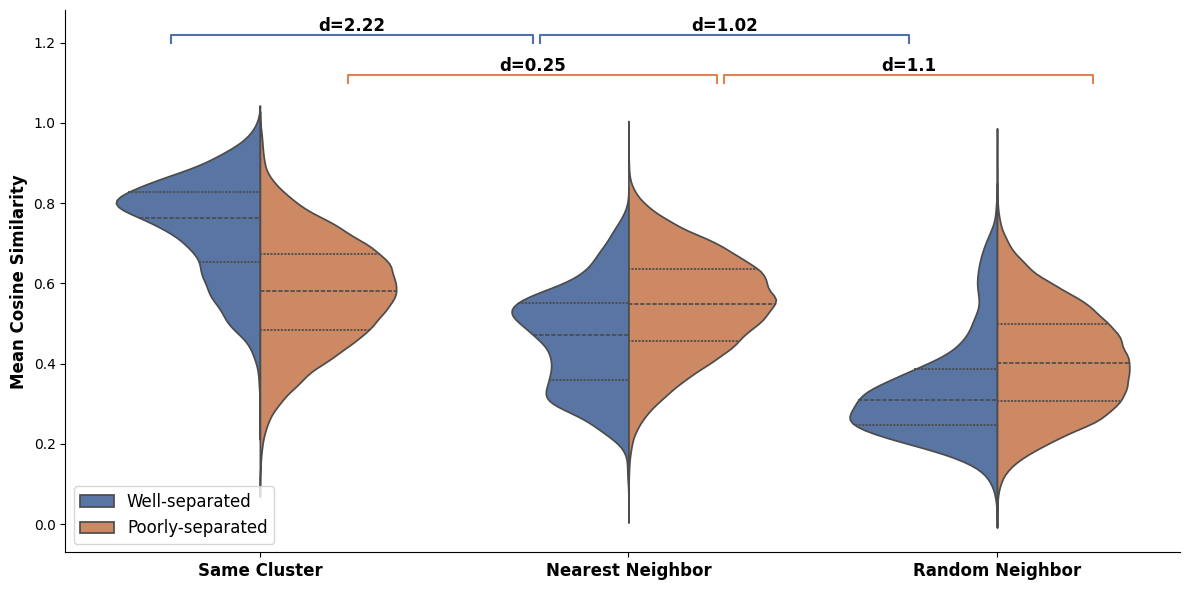

In [18]:
well_clusters = well_clusters.to_list()
fuzzy_clusters = fuzzy_clusters.to_list()
similarity_violin_plot(correlations, well_clusters, fuzzy_clusters, 'Cluster Label')